<a href="https://colab.research.google.com/github/ArturoAA95/TransmisionProblem/blob/main/TestTransmision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
import sys
import os
import scipy
from scipy.optimize import root_scalar
from scipy.optimize import brentq
from scipy.sparse.linalg import spsolve
import heapq

#Source term

In [204]:
def f_1(x, y):
  return .5*np.sin(2*np.pi*(x/200))*np.cos(2*np.pi*(x/200)) + 2

#Operator

In [205]:
def H1(a1, a2, a3, a4, x ,y):
  return min(a1, a2, a3, a4) + 1

def H2(a1, a2, a3, a4, x, y):
  a = min(a1, a2)
  b = min(a3, a4)
  c = f_1(x, y)
  if c > np.abs(a-b):
    return .5*(a + b + np.sqrt(2*c**2 - (a-b)**2))
  else:
    return c**2 + min(a, b)

def H(a1, a2, a3, a4, x, y):
  a = min(a1, a2)
  b = min(a3, a4)
  c = 1
  if c > np.abs(a-b):
    return .5*(a + b + np.sqrt(2*c**2 - (a-b)**2))
  else:
    return c**2 + min(a, b)

def S(a1, a2, a3, a4):
  return .25*(a1+a2+a3+a4)

#def G_Anis(z, a1, a2, a3, a4):
#  aux = max(0, z-a3, z-a4)
#  if aux
#  return np.sqrt( /  )

#Fast Marching Method -- Checked

In [206]:
def InitializeNarrowBand(NB, om, dist, N, H):
  for i in range(N):
    for j in range(N):
      if om[i, j] > 0 and om[i, j] < 3: #Run over eikonal
        if om[i+1, j] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        elif om[i-1, j] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        elif om[i, j+1] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        elif om[i, j-1] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        else:
          continue  #The index is not added to the narrow band
        new_dist = np.copy(aux)
        if new_dist < dist[i, j]:
          dist[i, j] = new_dist
          x = [i, j]
          heapq.heappush(NB, (new_dist, x))

def UpdateDistance(NB, om, dist, N, H, i_aux, j_aux):
    #Update the distance of i_aux, j_aux
    new_dist = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1], i_aux, j_aux)
    #Only update if the distance is smaller than the current distance
    if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        heapq.heappush(NB, (new_dist, [i_aux, j_aux]))


def FastMarchingMethod2D(NB, om, dist, N, H): #Solves Eikonal equation
  #Inicialice narrow band
  InitializeNarrowBand(NB, om, dist, N, H)
  #Compute solution
  #Loop until narrow band is empty
  while len(NB)>0 :
    #Pop the element with the least distance in the narrow band
    c_dist, c_vert = heapq.heappop(NB)
    i = int(c_vert[0])
    j = int(c_vert[1])
    #The vertex (i,j) becomes a boundary point
    om[i, j] = 0
    # Check if we have already poped the vertex
    if c_dist > dist[i, j]:
      continue
    #Update distance for neighbors of current_vertex
    #Update the distance of the neighbor upwards
    if om[i+1, j] > 0 and om[i+1, j] < 3: #Restrict to Eikonal
      i_aux = i+1
      j_aux = j
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor downwards
    if om[i-1, j] > 0 and om[i-1, j] < 3: #Restrict to Eikonal
      i_aux = i-1
      j_aux = j
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the right
    if om[i, j+1] > 0 and om[i, j+1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j+1
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the left
    if om[i, j-1] > 0 and om[i, j-1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j-1
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
  #Return the distance matrix
  return dist


#Interfase functions

In [207]:
#For 250
def I(i):
  return 110+int(15*np.sin((i+63)/40))

#Test building domain

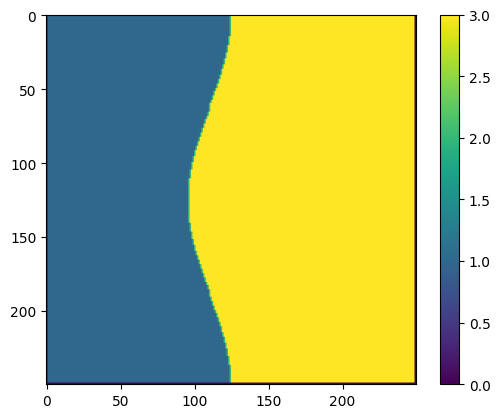

In [208]:
def CreateInterfase(om, k, N, I):
  for i in range(1, N-1):
    om[i, I(i)] = k

def Build_Eik_Brown(om, N):
  for i in range (1, N-1):
    j = 1
    while om[i,j] != 2 and j<N-1: #Eikonal
      om[i,j] = 1
      j = j+1
    j = j+1
    while j < N-1:  #Brownian
      om[i,j] = 3
      j = j+1

N = 250

#We give codes to each region of the domain
# 0 -> Fixed point (Boundary and non-used)
# 1 -> Eikonal
# 2 -> Interface
# 3 -> Brownian

om = np.zeros((N,N))
#Construction of Interface
CreateInterfase(om, 2, N, I)
#Construction of Domain
Build_Eik_Brown(om, N)

plt.imshow(om)
plt.colorbar()

#Test fast marching method

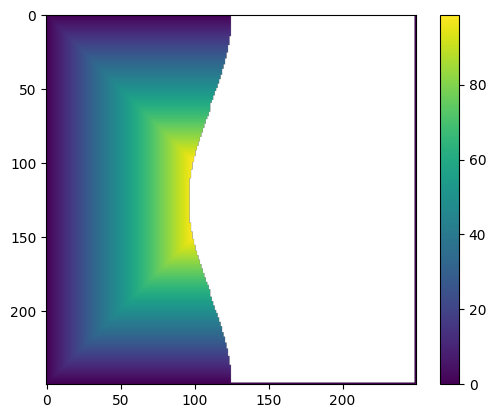

In [209]:
def InitializeDistances(om, N):
   dist = np.zeros((N,N))
   for i in range(N):
    for j in range(N):
       if om[i, j] > 0:
          dist[i, j] = np.inf
   return dist

Omega = np.copy(om)   ### We preserve the structure of the domain
dist = InitializeDistances(om, N)
NB = []
eik_0 = FastMarchingMethod2D(NB, Omega, dist, N, H)        ### Omega is modified
plt.imshow(eik_0)
plt.colorbar()

#Brownian system

In [210]:
from scipy import sparse

def HashTablesBrownian(om, N):
  #Create hash tables for Brownian
  C_to_P = {}
  P_to_C = {}
  dim = 0
  for i in range(N):
    for j in range(N):
      if om[i,j] == 3:
        C_to_P[i,j] = dim
        P_to_C[dim] = [i,j]
        dim = dim + 1
  return C_to_P, P_to_C, dim

#Give coordinates and receive position in vector
def Coord_to_Pos(x, y, C_to_P):
  return C_to_P[x,y]

#Give position in vector and receive coordinates
def Pos_to_Coord(l, P_to_C):
  return P_to_C[l]

def CreateMatrixBrownian(C_to_P, P_to_C, dim, om):
  #Create sparse matrix for Brownian
  A = sparse.csr_matrix((dim, dim))
  A = A.tolil()

  #Construct linear system for the Brownian region
  for l in range(dim):
    A[l,l] = -4
    x, y = Pos_to_Coord(l, P_to_C)
    #Check if (x,y) has a neighbor to the left and if it's in the Brownian region
    if om[x, y-1] == 3:
      A[l, Coord_to_Pos(x, y-1, C_to_P)] = 1
    #Check if (x,y) has a neighbor to the right and if it's in the Brownian region
    if om[x, y+1] == 3:
      A[l, Coord_to_Pos(x, y+1, C_to_P)] = 1
    #Check if (x,y) has a neighbor upwards and if it's in the Brownian region
    if om[x-1, y] == 3:
      m = Coord_to_Pos(x-1, y, C_to_P)
      A[l, m] = 1
    #Check if (x,y) has a neighbor downwards and if it's in the Brownian region
    if om[x+1, y] == 3:
      m = Coord_to_Pos(x+1, y, C_to_P)
      A[l, m] = 1

  A = A.tocsr()
  return A

#Functions to update Interfase
def Update_b(sol, CtoP, dim, om, I, N):
  b = np.zeros(dim)
  for i in range(1, N-1):
    x = i
    y = I(i)
    l = Coord_to_Pos(x, y+1, CtoP)
    b[l] = b[l] - sol[x, y]
    if om[x+1, y+1] != 3:
      b[l] = b[l] - sol[x+1, y+1]
    if om[x-1, y+1] != 3:
      b[l] = b[l] - sol[x-1, y+1]
  return b

#Receives vector obtained when solving Laplaces equation and copies it to the solution matrix
def Update_sol_I(sol, sol_brow, dim, N, CtoP, I, om):
  #print(CtoP)
  for i in range(1, N-1):
    x = i
    y = I(i)
    #print(x, y)
    l = Coord_to_Pos(x, y+1, CtoP)
    sol[x, y+1] = sol_brow[l]
    if om[x+1, y] == 3:
      #print(x+1, y)
      l = Coord_to_Pos(x+1, y, CtoP)
      sol[x+1, y] = sol_brow[l]
    if om[x-1, y] == 3:
      #print(x-1, y+1)
      l = Coord_to_Pos(x-1, y, CtoP)
      sol[x-1, y] = sol_brow[l]
  return sol

def Update_sol(sol, sol_brow, dim, PtoC):
  for l in range(dim):
    x, y = Pos_to_Coord(l, PtoC)
    sol[x, y] = sol_brow[l]
  return sol

#Test Brownian system

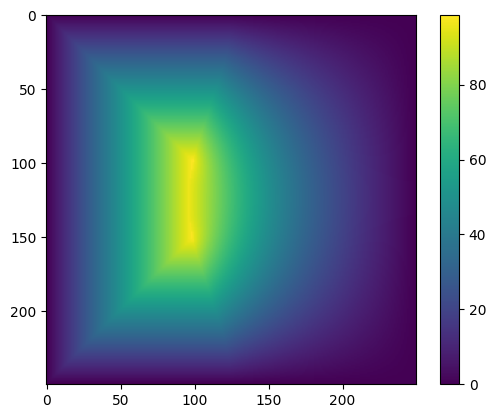

In [211]:
C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
A = CreateMatrixBrownian(C_to_P, P_to_C, dim, Omega)

#Initialize solution
b = Update_b(eik_0, C_to_P, dim, om, I, N)

#Actualiza_b(sol_0, dim, Iy, vT, hT, N)
x = spsolve(A, b)
sol = Update_sol(eik_0, x, dim, P_to_C)
#sol = Update_sol(eik_0, x, dim, N, C_to_P, f)
plt.imshow(sol)
plt.colorbar()

st = np.copy(sol)

#Interface
CreateInterfase(om, 2, N, I)

In [212]:
def Update_Interfase(sol_0, N, I, H):
  for i in range(1, N-1):
    x = i
    y = I(i)
    a_1 = sol_0[x, y+1]
    a_2 = sol_0[x, y-1]
    a_3 = sol_0[x+1, y]
    a_4 = sol_0[x-1, y]
    aux1 = H(a_1, a_2, a_3, a_4, x, y)
    if sol_0[x, y] > aux1:
      sol_0[x, y] = aux1

def InitializeOnePlayer(omega, CtoP, PtoC, N, H, dim, I, A):
  O = np.copy(omega)   ### We preserve the structure of the domain
  #Solve Eikonal equation in Brownian region
  dist = InitializeDistances(O, N)
  NB = []
  sol_0 = FastMarchingMethod2D(NB, O, dist, N, H)
  #Solve Laplace equation in Brownian region
  b = Update_b(sol_0, CtoP, dim, O, I, N)
  sol_brow = spsolve(A, b)
  sol_0 = Update_sol(sol_0, sol_brow, dim, PtoC)

  return sol_0

def Solve_One_Player(omega, iter, dim, N, A, CtoP, PtoC, I, H):
  #Initialize solution
  sol_0 = InitializeOnePlayer(omega, CtoP, PtoC, N, H, dim, I, A)
  #Fix the interphase
  CreateInterfase(omega, 0, N, I)
  #Iterate over iter
  for k in range(iter):
    print(k)
    #Update interfase
    Update_Interfase(sol_0, N, I, H)
    #Save information of the domain
    om = np.copy(omega)
    #Solve in the Eikonal region
    sol_0 = FastMarchingMethod2D([], om, sol_0, N, H)
    #Update the boundary for the Brownian region
    b = Update_b(sol_0, CtoP, dim, om, I, N)
    #Solve Laplace equation in Brownian region
    sol_brow = spsolve(A, b)
    #Update solution
    sol_0 = Update_sol_I(sol_0, sol_brow, dim, N, CtoP, I, om)

  sol_0 = Update_sol(sol_0, sol_brow, dim, PtoC)

  return sol_0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


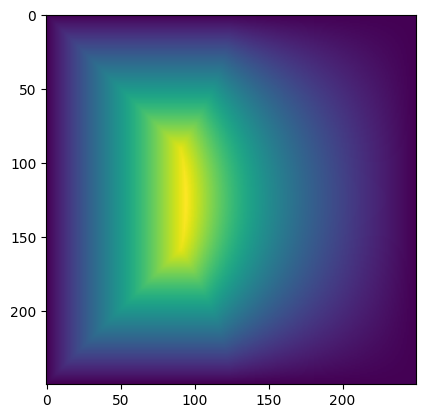

In [213]:
vv = Solve_One_Player(om, 50, dim, N, A, C_to_P, P_to_C, I, H)
plt.imshow(vv)

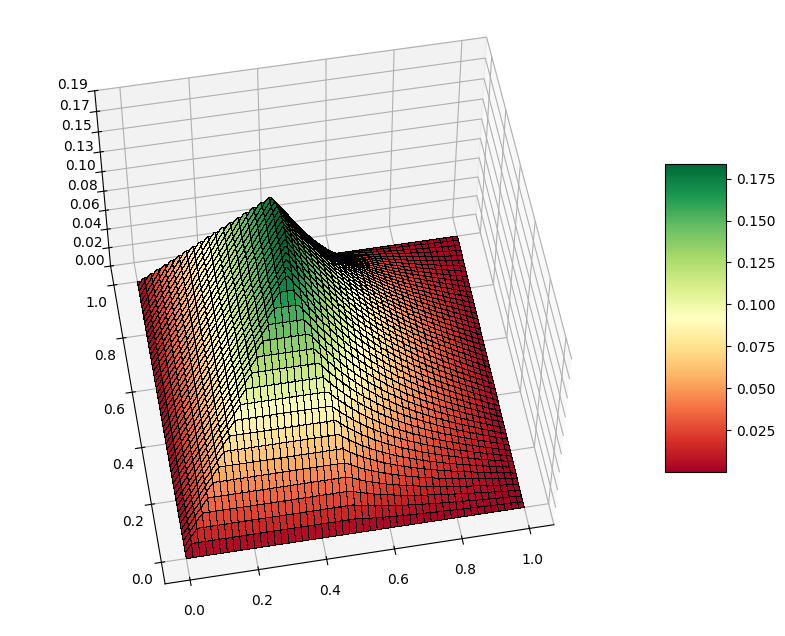

In [214]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 8))


# Make data.
# Get the shape of vv
rows, cols = vv.shape
# Create coordinate arrays with the same shape as vv
X, Y = np.indices(vv.shape)

# Scale X and Y to the desired range (e.g., -5 to 5)
x_range = np.linspace(0, 1, cols)
y_range = np.linspace(0, 1, rows)
X, Y = np.meshgrid(x_range, y_range)

# Plot the surface.
surf = ax.plot_surface(X, Y, vv/500, cmap='RdYlGn',
                       linewidth=.01, edgecolor='black', antialiased=False)

#cmap='bwr'
#cmap='seismic'
#cmap='viridis', edgecolor='green'
#rotate surface
ax.view_init(55, 260)
# Customize the z axis.
ax.set_zlim(np.min(vv/500), np.max(vv/500)) # Adjust z-axis limits based on vv values
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()